In [1]:
import mesa
import numpy as np
import random

In [2]:
class Edificio(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

class Camino(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.vecinos = []
    
    def definirVecinos(self, binario):
        x = self.pos[0]
        y = self.pos[1]

        vecindario = [(x-1,y), (x,y-1), (x,y+1), (x+1,y)]
        vecinos = []

        for i in range(len(binario)):
            if binario[i] == "1":
                vecinos.append(vecindario[i])
        
        self.vecinos = vecinos

class Glorieta(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

class Semaforo(mesa.Agent):
    def __init__(self, unique_id, model, tiempoDeCambio):
        super().__init__(unique_id, model)
        self.color = "green"
        self.contador = 0
        self.tiempoDeCambio = tiempoDeCambio
    
    def step(self):
        self.contador += 1
        if self.contador%self.tiempoDeCambio == 0:
            if self.color == "red":
                self.color = "green"
            else:
                self.color = "red"
            self.contador = 0

class Estacionamiento(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.entradas = []

    def definirEntradas(self):
        entradas = []
        vecinos = self.model.grid.get_neighbors(self.pos, False)
        for vecino in vecinos:
            if isinstance(vecino, Camino):
                entradas.append(vecino.pos)
        self.entradas = entradas

In [3]:
class Auto(mesa.Agent):
    def __init__(self, unique_id, model, inicio, destino):
        super().__init__(unique_id, model) 
        self.direccion = [0,0]   
        self.reduccionVel = 1
        self.contador = 1
        self.inicio = inicio
        self.destino = destino
        self.ruta = self.a_estrella()
        self.pasos = 0


    def distanciaManhattan(self, pos1, pos2):
        x1 = pos1[0]
        x2 = pos2[0]

        y1 = pos1[1]
        y2 = pos2[1]

        return abs(x1-x2) + abs(y1-y2)
    
    def a_estrella(self):

        dist = [[float('inf') for x in range(self.model.ancho)] for y in range(self.model.alto)]
        ruta = [[() for x in range(self.model.ancho)] for y in range(self.model.alto)]

        def reconstruirRuta():
            camino = []
            camino.append(self.destino)
            pos = ruta[self.destino[0]][self.destino[1]]
            while pos != self.inicio:
                camino.append(pos)
                pos = ruta[pos[0]][pos[1]]
            return list(reversed(camino))

        abiertas = []
        abiertas.append(self.inicio)
        dist[self.inicio[0]][self.inicio[1]] = 0
        ruta[self.inicio[0]][self.inicio[1]] = self.inicio

        while len(abiertas) > 0:

            pos = abiertas.pop(0)
            
            vecinos = []
            celda = self.model.grid.get_cell_list_contents([pos])
            for agente in celda:
                if isinstance(agente, Camino):
                    vecinos = agente.vecinos
                elif isinstance(agente, Estacionamiento):
                    vecinos = agente.entradas
            
            for vecino in vecinos:
                if dist[vecino[0]][vecino[1]] == float('inf'):
                    abiertas.append(vecino)
                    dist[vecino[0]][vecino[1]] = dist[pos[0]][pos[1]] + 1
                    ruta[vecino[0]][vecino[1]] = pos
    
        return reconstruirRuta()


    def validarPosicion(self,pos):
        x = pos[0]
        y = pos[1]
        noSalir = 0 <= x < self.model.ancho and 0 <= y < self.model.alto
        noChocar = True
        if noSalir:
            celda = self.model.grid.get_cell_list_contents([(x,y)])
            for agente in celda:
                if isinstance(agente, Auto) or isinstance(agente, Edificio) or isinstance(agente, Glorieta):
                    noChocar = False
        return noSalir and noChocar
    

    def sigMovimiento(self):
        sigPos = self.ruta[0]
        if self.validarPosicion(sigPos):
            pos = self.ruta.pop(0)
            self.model.grid.move_agent(self, pos)

    def step(self):
        noParar = True
        celda = self.model.grid.get_cell_list_contents([(self.pos)])
        for agente in celda:
            if isinstance(agente, Semaforo):
                if agente.color == "red":
                    noParar = False
        
        if noParar:
            self.sigMovimiento()
            self.pasos += 1
 
        if self.pos == self.destino:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            self.model.numAgentes -= 1
            self.model.movimientos.append((self.unique_id, self.destino[0], self.destino[1]))
            self.model.movimientosAux.append((self.unique_id, self.destino[0], self.destino[1]))
            self.model.pasosParaTerminar.append(self.pasos)
        else:
            self.model.movimientos.append((self.unique_id, self.pos[0], self.pos[1]))
            self.model.movimientosAux.append((self.unique_id, self.pos[0], self.pos[1]))

        

In [4]:
class Ciudad(mesa.Model):
    def __init__(self, N, tiempoDeCambio):

        # 0 0000
        # 1 0001
        # 2 0010
        # 3 0011
        # 4 0100
        # 5 0101
        # 6 0110
        # 7 0111
        # 8 1000
        # 9 1001
        # A 1010
        # B 1011
        # C 1100
        # D 1101
        # E 1110
        # F 1111

        mapa = [
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
        ]

        mapa = [
            ["4", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "C", "8", "8"],
            ["4", "E", "A", "A", "A", "A", "A", "A", "A", "E", "A", "A", "E", "E", "A", "A", "A", "A", "E", "E", "A", "A", "B", "A"],
            ["5", "C", "H", "H", "H", "H", "H", "H", "H", "S", "H", "H", "5", "C", "3", "A", "H", "H", "5", "C", "H", "H", "3", "A"],
            ["5", "D", "S", "H", "H", "H", "H", "H", "H", "H", "H", "H", "5", "C", "3", "A", "H", "S", "D", "C", "H", "H", "3", "A"],
            ["5", "C", "H", "H", "H", "H", "H", "H", "H", "H", "H", "S", "D", "C", "3", "A", "H", "H", "5", "D", "S", "H", "3", "A"],
            ["5", "C", "H", "H", "H", "H", "S", "H", "H", "H", "H", "H", "5", "C", "3", "A", "H", "H", "5", "C", "H", "H", "3", "A"],
            ["5", "C", "C", "C", "C", "C", "E", "C", "C", "C", "C", "C", "D", "C", "3", "B", "5", "5", "5", "5", "5", "5", "3", "A"],
            ["5", "C", "A", "A", "A", "A", "A", "A", "E", "A", "A", "A", "D", "C", "3", "B", "3", "3", "3", "3", "3", "3", "3", "A"],
            ["5", "C", "H", "H", "H", "3", "A", "H", "S", "H", "H", "H", "5", "C", "3", "A", "H", "H", "3", "A", "H", "H", "3", "A"],
            ["5", "C", "H", "H", "H", "3", "A", "H", "H", "H", "H", "H", "5", "C", "3", "A", "H", "H", "3", "A", "H", "S", "B", "A"],
            ["5", "C", "H", "H", "S", "B", "A", "H", "H", "H", "H", "S", "D", "C", "3", "B", "S", "H", "3", "A", "H", "H", "3", "A"],
            ["5", "C", "H", "H", "H", "3", "A", "H", "H", "H", "H", "H", "5", "C", "3", "A", "H", "H", "3", "A", "H", "H", "3", "A"],
            ["5", "C", "C", "C", "C", "E", "E", "C", "C", "C", "C", "C", "C", "8", "8", "A", "C", "C", "E", "E", "C", "C", "B", "A"],
            ["5", "C", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "4", "G", "G", "2", "A", "A", "A", "A", "A", "A", "B", "A"],
            ["5", "D", "5", "5", "5", "5", "5", "5", "5", "5", "5", "5", "4", "G", "G", "2", "5", "5", "5", "5", "5", "5", "B", "A"],
            ["5", "D", "3", "3", "3", "3", "7", "7", "3", "3", "3", "3", "5", "1", "1", "3", "3", "3", "3", "3", "3", "3", "3", "A"],
            ["5", "C", "H", "H", "H", "H", "5", "C", "H", "H", "H", "H", "5", "C", "3", "A", "H", "H", "H", "H", "H", "H", "3", "A"],
            ["5", "D", "S", "H", "H", "H", "5", "C", "H", "H", "H", "H", "5", "C", "3", "A", "H", "S", "H", "S", "H", "H", "3", "A"],
            ["5", "C", "H", "H", "H", "H", "5", "C", "H", "H", "H", "H", "5", "C", "3", "B", "C", "E", "C", "E", "C", "C", "B", "A"],
            ["5", "C", "H", "H", "H", "H", "5", "C", "H", "H", "H", "H", "5", "C", "3", "B", "A", "A", "A", "E", "A", "A", "B", "A"],
            ["5", "C", "H", "H", "H", "S", "D", "D", "S", "H", "H", "H", "5", "C", "3", "A", "H", "H", "H", "S", "H", "H", "3", "A"],
            ["5", "C", "H", "H", "H", "H", "5", "C", "H", "H", "H", "H", "5", "C", "3", "A", "H", "H", "H", "H", "H", "H", "3", "A"],
            ["5", "D", "5", "5", "5", "5", "5", "5", "5", "5", "5", "5", "5", "5", "7", "7", "5", "5", "5", "5", "5", "5", "7", "2"],
            ["1", "1", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "3", "2"],
        ]

        mapaSemaforos = [
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "V", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "V", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "R", "R", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", "V", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", "V", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", "R", "R", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            ["R", "R", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", "V", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", "V", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "V", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "V", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "R", "R"],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "V", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "V", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "R", "R", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "R", "R", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "V", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", "V", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " ", " "],
        ]

        self.numAgentes = N
        self.alto = 24
        self.ancho = 24
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.MultiGrid(self.ancho, self.alto, False)
        self.running = True
        posiciones = [(x,y) for x in range(self.ancho) for y in range(self.alto)]
        self.n = N
        posicionesLibres = []
        posEstacionamientos = []
        self.spawners = []
        self.movimientos = []
        self.movimientosAux = []
        self.movimientosPorPaso = []
        self.tiempo = 0
        self.pasosParaTerminar = []
        self.promedioPasos = 0

        self.datacollector = mesa.DataCollector(
            model_reporters={"Tiempo": "tiempo", "PromedioPasos":"promedioPasos"}
        )
        
        def hex_a_bin(hex_num):
            bin_num = bin(int(hex_num, 16))[2:]
            return str(bin_num.zfill(4))

        def construirMapa(mapa):
            mapa = list(reversed(mapa))
            caminos = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F"]
            for i in range(len(mapa)):
                for j in range(len(mapa[0])):
                    if mapa[i][j] != " " and mapa[i][j] not in caminos:
                        if mapa[i][j] == "H":
                            a = Edificio(self.n, self)
                        elif mapa[i][j] == "S":
                            a = Estacionamiento(self.n, self)
                            posEstacionamientos.append((j,i))
                        elif mapa[i][j] == "G":
                            a = Glorieta(self.n, self)
                        elif mapa[i][j] == "V":
                            a = Semaforo(self.n, self, tiempoDeCambio)
                            a.color = "green"
                        elif mapa[i][j] == "R":
                            a = Semaforo(self.n, self, tiempoDeCambio)
                            a.color = "red"
                        self.n += 1
                        self.schedule.add(a)
                        self.grid.place_agent(a,(j,i))
                    elif mapa[i][j] != " " and mapa[i][j] in caminos:
                        posicionesLibres.append((j,i))
                        binario = hex_a_bin(mapa[i][j])
                        a = Camino(self.n, self)
                        self.n += 1
                        self.schedule.add(a)
                        self.grid.place_agent(a,(j,i))
                        a.definirVecinos(binario)

        construirMapa(mapa)
        construirMapa(mapaSemaforos)

        agentes = self.schedule.agents
        for agente in agentes:
            if isinstance(agente, Estacionamiento):
                agente.definirEntradas()

        entradas = []
        for pos in posEstacionamientos: 
            vecinos = self.grid.get_neighbors(pos, False)
            for vecino in vecinos:
                if isinstance(vecino, Camino):
                    entradas.append(vecino.pos)

        random.shuffle(posEstacionamientos)
        posEstacionamientos2 = list(reversed(posEstacionamientos))

        n = 0
        for i in range(self.numAgentes):
                inicio = posEstacionamientos[i]
                destino = posEstacionamientos2[i]
                a = Auto(n, self, inicio, destino)
                a.inicio = inicio
                n += 1
                self.schedule.add(a)
                self.grid.place_agent(a,inicio)
                self.spawners.append((a.unique_id, a.inicio[0], a.inicio[1]))
                

    def step(self):
        self.tiempo += 1
        self.promedioPasos = np.mean(self.pasosParaTerminar)
        self.datacollector.collect(self)
        self.schedule.step()
        if self.numAgentes == 0:
            self.running = False
        self.movimientosPorPaso.append(self.movimientosAux)
        self.movimientosAux = []
        

In [5]:
import json
model = Ciudad(10, 15)
while model.running:
    model.step()
lista = model.movimientosPorPaso
jsonD = [[dict(id=id, x=x, y=y) for id, x, y in paso] for paso in lista]
print(lista)
print(jsonD)
print(model.movimientos)

[[(2, 19, 19), (9, 6, 3), (8, 17, 6), (6, 15, 13), (5, 19, 4), (7, 6, 17), (0, 19, 5), (3, 1, 20), (1, 18, 20), (4, 1, 6)], [(9, 6, 2), (0, 18, 5), (7, 5, 17), (3, 1, 19), (6, 14, 13), (5, 18, 4), (1, 18, 19), (4, 1, 5), (2, 19, 18)], [(2, 19, 17), (4, 1, 4), (5, 17, 4), (3, 1, 18), (0, 17, 5), (9, 6, 1), (6, 14, 14), (1, 18, 18), (7, 4, 17)], [(3, 1, 17), (6, 14, 15), (9, 7, 1), (0, 16, 5), (1, 18, 17), (2, 20, 17), (5, 16, 4), (4, 1, 3), (7, 3, 17)], [(6, 14, 16), (9, 8, 1), (7, 2, 17), (3, 1, 16), (5, 15, 4), (4, 1, 2), (1, 19, 17), (2, 21, 17), (0, 15, 5)], [(7, 1, 17), (3, 1, 15), (1, 20, 17), (0, 15, 6), (6, 14, 17), (9, 9, 1), (5, 15, 5), (2, 22, 17), (4, 1, 1)], [(1, 21, 17), (0, 15, 7), (3, 1, 14), (4, 2, 1), (7, 1, 16), (9, 10, 1), (2, 22, 18), (6, 14, 18), (5, 15, 6)], [(9, 11, 1), (1, 22, 17), (4, 3, 1), (0, 15, 8), (2, 22, 19), (7, 1, 15), (6, 14, 19), (5, 15, 7), (3, 1, 13)], [(4, 4, 1), (6, 14, 20), (1, 22, 18), (9, 12, 1), (0, 15, 9), (2, 22, 20), (5, 15, 8), (7, 1, 14)

c:\Users\meist\OneDrive\Escritorio\Multiagentes\env\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\meist\OneDrive\Escritorio\Multiagentes\env\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\meist\OneDrive\Escritorio\Multiagentes\env\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\meist\OneDrive\Escritorio\Multiagentes\env\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[]

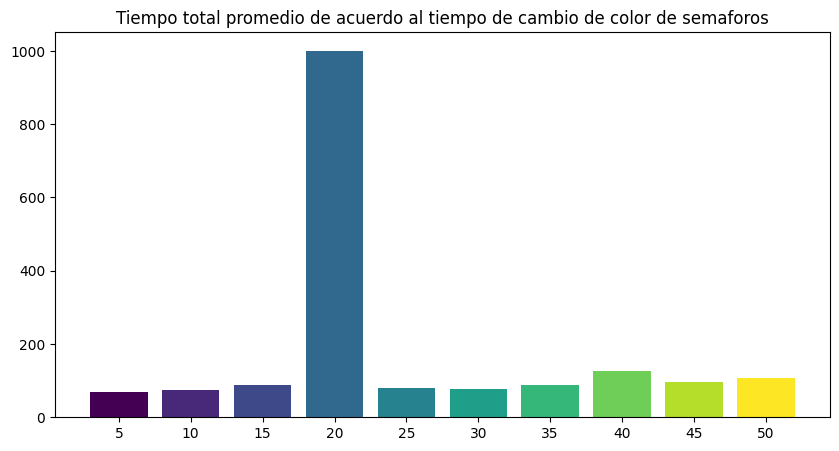

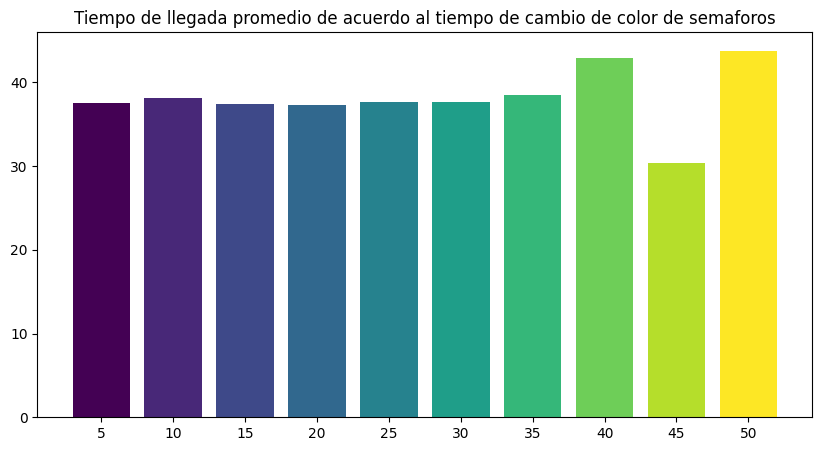

In [6]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

tiempoPromedio = []
pasosPromedio = []
nombres = []

for i in range(1,11):
    tPromedio = []
    pPromedio = []
    parametros = {"N": 15, "tiempoDeCambio": i*5}
    br = mesa.batch_run(Ciudad, parametros, iterations=1)
    for r in br:
        tPromedio.append(r['Tiempo'])
        pPromedio.append(r['PromedioPasos'])
    tiempoPromedio.append(np.mean(tPromedio))
    pasosPromedio.append(np.mean(pPromedio))
    nombres.append(str(i*5))


courses = nombres
values = tiempoPromedio
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color=plt.cm.viridis(np.linspace(0, 1, len(courses))))
plt.title("Tiempo total promedio de acuerdo al tiempo de cambio de color de semaforos")
plt.plot()

courses = nombres
values = pasosPromedio
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color=plt.cm.viridis(np.linspace(0, 1, len(courses))))
plt.title("Tiempo de llegada promedio de acuerdo al tiempo de cambio de color de semaforos")
plt.plot()



In [7]:

# Importar la librería Flask
from flask import Flask

# Crear una instancia de la clase Flask
app = Flask(__name__)

# Definir una ruta para la página principal
@app.route('/')
def home():
    model = Ciudad(10)
    while model.running:
        model.step()
    return "Modelo iniciado correctamente"

@app.route('/iniciadores')
def iniciadores():
    lista = model.spawners
    jsonD = [dict(id=id, x=x, y=y) for id, x, y in lista] 
    response = app.response_class(
        response=json.dumps(jsonD),
        status=200,
        mimetype='application/json'
    )
    return response

@app.route('/movimientos')
def movimientos():
    lista = model.movimientos
    jsonD = [dict(id=id, x=x, y=y) for id, x, y in lista] 
    response = app.response_class(
        response=json.dumps(jsonD),
        status=200,
        mimetype='application/json'
    )
    return response

@app.route('/movimientosPorPaso')
def movimientosPorPaso():
    lista = model.movimientosPorPaso
    jsonD = [dict(items = [dict(id=id, x=x, y=y) for id, x, y in paso]) for paso in lista]
    response = app.response_class(
        response=json.dumps(jsonD),
        status=200,
        mimetype='application/json'
    )
    return response

# Correr el servidor
if __name__ == '__main__':
    app.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [17/Nov/2023 16:31:00] "GET /iniciadores HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:31:01] "GET /movimientos HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:31:38] "GET /iniciadores HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:31:39] "GET /movimientos HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:32:41] "GET /iniciadores HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:32:42] "GET /movimientos HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:32:42] "GET /movimientos HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:33:13] "GET /movimientosPorPaso HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:34:22] "GET /iniciadores HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:34:23] "GET /movimientos HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:34:23] "GET /movimientos HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:35:34] "GET /iniciadores HTTP/1.1" 200 -
127.0.0.1 - - [17/Nov/2023 16:35:35] "GET /movimientos HTTP/1.1" 200 -
127.0.0.1 - -

In [ ]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
import nest_asyncio
nest_asyncio.apply()

def agent_portrayal(agent):

    if isinstance(agent, Camino):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 0,
                     "Color": "white",
                     "w": 1,
                     "h": 1}

    elif isinstance(agent, Edificio):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 0,
                     "Color": "blue",
                     "w": 1,
                     "h": 1}

    elif isinstance(agent, Glorieta):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 0,
                     "Color": "brown",
                     "w": 1,
                     "h": 1}
        
    elif isinstance(agent, Estacionamiento):
        portrayal = {"Shape": "rect",
                     "Filled": "true",
                     "Layer": 2,
                     "Color": "yellow",
                     "w": 1,
                     "h": 1}

    elif isinstance(agent, Semaforo):
        portrayal = {"Shape": "circle",
                     "Filled": "false",
                     "Layer": 0,
                     "Color": agent.color,
                     "r": 0.75}
        
    elif isinstance(agent, Auto):
        portrayal = {"Shape": "circle",
                     "Filled": "false",
                     "Layer": 0,
                     "Color": "orange",
                     "r": 0.5}
    return portrayal


grid = CanvasGrid(agent_portrayal, 24, 24, 400, 400)

parametros = {"N":15, "tiempoDeCambio":15}
server = ModularServer(Ciudad,
                       [grid],
                       "Modelo de Ciudad",
                       parametros)

server.launch()

Interface starting at http://127.0.0.1:8521
Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
